In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd

# Some custom functions
import ma_codes as codes
from ma_codes import mysize, mymap, gray_red

folder = "/mnt/platte_2/Data_Objects/Scanpy_Objects/"

sc.settings.verbosity = 3               # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_version_and_date()

Running Scanpy 1.5.1, on 2020-07-26 13:21.


In [ ]:
import diffxpy.api as de
import warnings
warnings.filterwarnings("ignore")

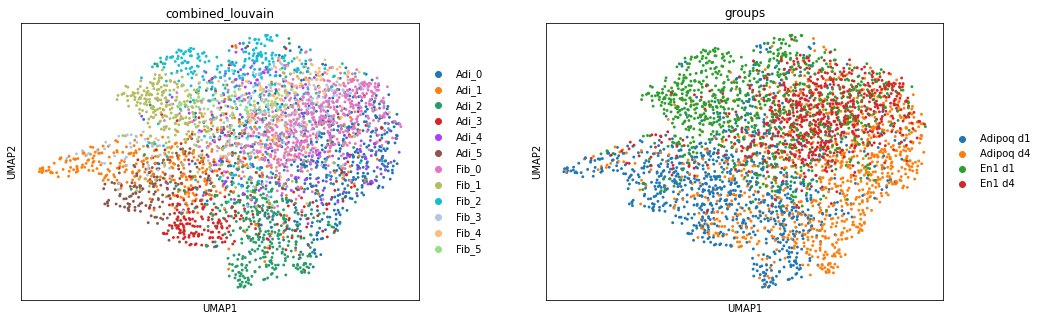

In [10]:
plt.rcParams['figure.figsize'] = (7, 5)

## Load object
adata = sc.read(folder + "200614_Shruthi_SCRB_AdiFibs_combined_counts.h5ad")
sc.pl.umap(adata, color = ["combined_louvain", "groups"], wspace = 0.2)

### Run Differential Gene Expression Adipoq day 1 vs day 4
Diffxpy needs raw count data as input, and at the current state of time will only perform pairwise test.  
Therefor, we need to generate an adata_raw object that contains only the subset (e.g. cell type, group) and the two conditions of interest which will then be used by diffxpy. Set the ref Parameter to whichever group you would like to define as baseline

In [ ]:
## Recommendation from Malte, scale the total number of counts beforehand
adata.obs["n_counts_scaled"] = adata.obs["n_counts"]/adata.obs["n_counts"].mean()

In [6]:
adata.obs.groups.cat.categories

Index(['Adipoq d1', 'Adipoq d4', 'En1 d1', 'En1 d4'], dtype='object')

filtered out 2944 genes that are detected in less than 5 cells
(1987, 20009)


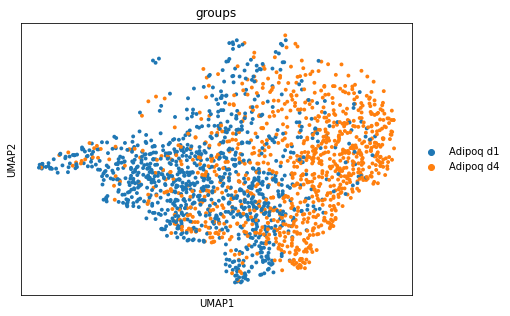

In [24]:
subset = ["Adipoq d1", "Adipoq d4"]
adata_raw = codes.generate_count_object(adata, condition = "groups", cell_type_label = "groups",
                                        cell_type = subset, ref = "Adipoq d1", min_cells = 5,
                                        subset = subset)

In [23]:
## check if this is indeed count data (obviously this wont work if you didn’t save the raw counts layer in the object)
adata_raw.X[:5, :10].todense()

matrix([[2., 0., 1., 0., 0., 0., 0., 5., 0., 3.],
        [0., 0., 0., 0., 0., 1., 0., 3., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 7., 0., 1.],
        [3., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

### Run Diffxpy (will take a while)
You have to manually define the Formula though, depending on which factor you want to test for (e.g. condition, treatment etc.) In this case, we set it to _groups_ as that label distinguishes the cells.

In [26]:
print("Started Diffxpy Calculation:\t%s" %codes.timestamp())

de_test = de.test.wald(data = adata_raw.X, 
                       formula_loc = "~ 1 + groups",
                       factor_loc_totest = "groups",
                       gene_names = adata_raw.var_names, sample_description = adata_raw.obs,
                       noise_model = "nb", size_factors = "n_counts_scaled")

print("Finished Diffxpy Calculation:\t%s" %codes.timestamp())

Started Diffxpy Calculation:	26-07-2020 13:38:54
training location model: True
training scale model: True
iter   0: ll=25654063.934113
caught 173 linalg singular matrix errors
iter   1: ll=24913053.157824, converged: 0.00% (loc: 1.53%, scale update: False), in 11.29sec
iter   2: ll=24694441.572310, converged: 0.00% (loc: 1.53%, scale update: False), in 11.04sec
iter   3: ll=24678185.059307, converged: 0.00% (loc: 1.53%, scale update: False), in 10.62sec
iter   4: ll=24678071.862851, converged: 0.00% (loc: 1.53%, scale update: False), in 10.63sec
iter   5: ll=24678070.549833, converged: 0.00% (loc: 36.40%, scale update: False), in 10.51sec
iter   6: ll=22586908.723752, converged: 0.00% (loc: 0.00%, scale update: True), in 110.94sec
caught 173 linalg singular matrix errors
iter   7: ll=22585500.960504, converged: 0.00% (loc: 1.40%, scale update: False), in 10.18sec
iter   8: ll=22585436.051353, converged: 0.00% (loc: 4.99%, scale update: False), in 10.56sec
iter   9: ll=22585434.093113, 

iter  84: ll=22561372.422605, converged: 99.99% (loc: 99.99%, scale update: True), in 0.55sec
iter  85: ll=22561372.422605, converged: 99.99% (loc: 100.00%, scale update: False), in 0.44sec
iter  86: ll=22561372.422605, converged: 99.99% (loc: 100.00%, scale update: False), in 0.41sec
iter  87: ll=22561372.422605, converged: 99.99% (loc: 100.00%, scale update: False), in 0.41sec
iter  88: ll=22561372.422605, converged: 100.00% (loc: 100.00%, scale update: True), in 0.67sec
iter  89: ll=22561372.422604, converged: 100.00% (loc: 100.00%, scale update: False), in 0.40sec
iter  90: ll=22561372.422604, converged: 100.00% (loc: 100.00%, scale update: False), in 0.40sec
iter  91: ll=22561372.422604, converged: 100.00% (loc: 100.00%, scale update: True), in 0.47sec
iter  92: ll=22561372.422604, converged: 100.00% (loc: 100.00%, scale update: False), in 0.41sec
iter  93: ll=22561372.422604, converged: 100.00% (loc: 100.00%, scale update: False), in 0.41sec
iter  94: ll=22561372.422604, converge

In [28]:
## Export Table
res = codes.tidy_table(de_test, adata, cells = adata_raw.obs_names, ids = subset, group_by = "groups",
                       qval_thresh = 1.0)
res.head()

(20009, 10)
(20009, 10)


,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll,pct.Adipoq d1,pct.Adipoq d4
20008,eGFP,0.0,0.0,0.879099,128.689482,False,1.781857e-09,0.879099,0.040242,-10134.895972,1.000000,1.000000
11403,Uqcrq,0.0,0.0,0.726362,25.420232,False,3.143296e-08,0.726362,0.054202,-6994.483066,0.921860,0.946721
11454,Rpl18a,0.0,0.0,0.981040,40.634122,False,2.616756e-08,0.981040,0.040124,-7900.809286,0.983185,0.993852
11457,Bola3,0.0,0.0,1.033571,2.102164,False,1.327490e-07,1.033571,0.119320,-2420.080656,0.243323,0.361680
3262,Ribc2,0.0,0.0,1.080758,0.612481,False,1.985457e-07,1.080758,0.113000,-1711.497159,0.118694,0.385246


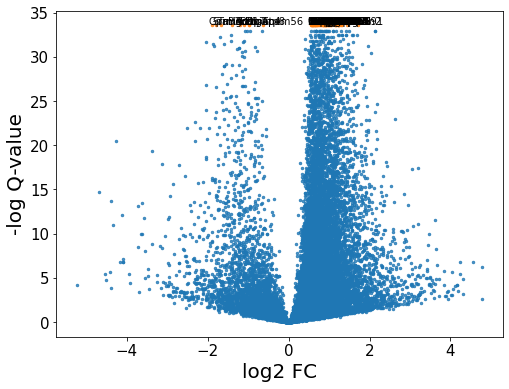

In [31]:
codes.volcano_plot(res, fdr_thresh = 33, adj_p_val = "qval", log_FC = "log2fc",
                   gene = "gene", figsize = (8, 6), save = None)

In [ ]:
## If you want you can filter the Table manually
res = res[res.qval < 0.05].copy()
res = res[(res.log2fc > 0.5) | (res.log2fc < -0.5)].copy()

In [32]:
## Save the Table
out_folder = "/home/agando/Documents/Meshal/PhD_Scripts/short_scripts/Rinkevich/"\
             "Shruthi_Adipoc/SCRB-seq/Data/DGE_by_day/"
res.to_csv(out_folder + "diffxpy_AdipoqD1_vs_AdipoqD4.txt", sep = "\t", index = False)

### Some quick overview Plots

In [33]:
res = res[res.qval < 0.05].copy()
min_pct_thresh = 0.1

up_genes = res[(res.log2fc > 1) & (res.loc[:, "pct.Adipoq d1"] > min_pct_thresh)].loc[:, "gene"].values
print(len(up_genes))
down_genes = res[(res.log2fc < -1) & (res.loc[:, "pct.Adipoq d4"] > min_pct_thresh)].loc[:, "gene"].values
print(len(down_genes))

724
114


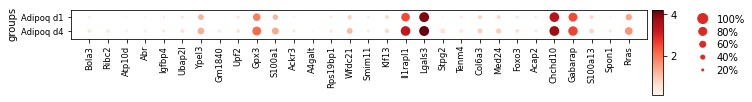

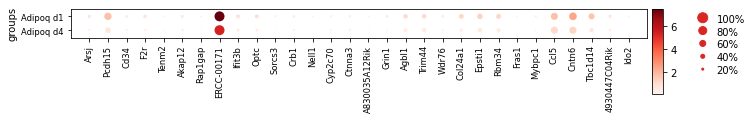

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[10.5, 0, 0.2, 0.5, 0.25])

In [36]:
cells = adata.obs.groups.isin(subset)
sc.pl.dotplot(adata[cells], var_names = up_genes[:30], groupby = "groups")
sc.pl.dotplot(adata[cells], var_names = down_genes[:30], groupby = "groups")

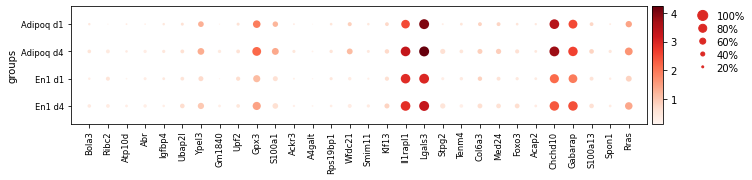

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[10.5, 0, 0.2, 0.5, 0.25])

In [37]:
sc.pl.dotplot(adata, var_names = up_genes[:30], groupby = "groups")